# Model Selection

## Packages

We begin by loading in necessary software packages, introducing options for saving the results, and software for computing PSIS LOO in Python.

In [1]:
from __future__ import division # For Python 2 compatibility
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import seaborn as sns
#%matplotlib notebook

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = 'core_models.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

# write out generated plots
save_plots = True

## Load Data

In [3]:
# load data
datafiles = {
    'seaflow':'data/SeaFlow_PSD_hourlyCOUNT_v3_regrid-25-8_day2.nc',
    #'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
    'zinser':'data/Zinser_SizeDist_logtransform-25-7.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

size_units = 'fg C cell$^{-1}$'

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded[dataname]:
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    elif 'abundance' in data_gridded[dataname]:
        logging.warning('{}: Using "abundance" data to generate count data for the model.'.format(dataname))
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafiles[dataname]))
        
    
    # add description
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

## Process Data

In [4]:
# prepare data for Stan model

seaflow_filter_par = False

if 'data' not in globals():
    data = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = None
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        if limit_days is None:
            limit_days = int(np.ceil(data[dataname]['t_obs'][-1]/1440))
        
        if seaflow_filter_par:
            # median filter PAR
            # see: medianfilter_par.ipynb
            n = len(data_gridded[dataname]['PAR'])
            wsh = 30 # half of median filter window size; window size is 2*wsh+1
            par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
        else:
            par = data_gridded[dataname]['PAR']
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        
        if not np.all(ind_obs):
            print('{}: limit_days is set to {}, removing {}/{} observation times'.format(dataname, limit_days, ind_obs.size-np.count_nonzero(ind_obs), ind_obs.size))
        
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    if use_testdata:
        # load cross-validation testing indices and add them to data
        data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
        # remove last index, so that dimensions agree
        data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    else:
        # set all indices to zero
        data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
        
    # switch on or off data fitting
    data[dataname]['prior_only'] = int(prior_only)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

zinser: limit_days is set to 2, removing 1/25 observation times


## Model List

In [5]:
# desc_model = {
#     #'m1':'m1',
#     'm2':'m2',
#     #'m3':'m3',
#     'm4':'m4',
#     #'m5':'m5',
#     #'m6':'m6',
#     #'m7':'m7',
#     #'m8':'m8',
#     #'m9':'m9',
#     #'m10':'m10',
#     #'m11':'m11',
#     #'m12':'m12',
#     #'m13':'m13',
#     #'m14':'m14',
#     #'m3u':'m3u',
#     #'m6u':'m6u',
#     #'m7u':'m7u',
#     #'m8u':'m8u',
#     #'m9u':'m9u',
#     #'m11u':'m11u',
#     'm12u':'m12u',
#     #'m13u':'m13u',
#     #'m14u':'m14u',
#     'm15':'m15',
#     'm16':'m16',
#     'm4s6':'m4 + spline6',
#     'm12us6':'m12u + spline6',
#     'm15s6':'m15 + spline6',
#     'm16s6':'m16 + spline6',
# }
desc_model = {
    'm1':'m$_\mathrm{bfx}$', 
    'm2':'m$_\mathrm{bmx}$', 
    'm3':'m$_\mathrm{emx}$', 
    'm4':'m$_\mathrm{bmb}$', 
    'm5':'m$_\mathrm{bmb–}$', # using en-dash here
    'm6':'m$_\mathrm{eme–}$', 
    'm7':'m$_\mathrm{eme}$', 
    'm8':'m$_\mathrm{ele–}$', 
    'm9':'m$_\mathrm{ele}$', 
    'm10':'m$_\mathrm{blb–}$', 
    'm11':'m$_\mathrm{emb–}$', 
    'm12':'m$_\mathrm{emb}$', 
    'm13':'m$_\mathrm{elb–}$',
    'm14':'m$_\mathrm{elb}$',
    'm3u':'m$_\mathrm{pmx}$', 
    'm6u':'m$_\mathrm{pmp–}$', 
    'm7u':'m$_\mathrm{pmp}$', 
    'm8u':'m$_\mathrm{plp–}$', 
    'm9u':'m$_\mathrm{plp}$', 
    'm11u':'m$_\mathrm{pmb–}$', 
    'm12u':'m$_\mathrm{pmb}$', 
    'm13u':'m$_\mathrm{plb–}$',
    'm14u':'m$_\mathrm{plb}$',
    'm15':'m$_\mathrm{fmb}$',
    'm16':'m$_\mathrm{fmf}$',
    'm4s6':'m$_\mathrm{btb}$', 
    'm12us6':'m$_\mathrm{ptb}$', 
    'm15s6':'m$_\mathrm{ftb}$',
    'm16s6':'m$_\mathrm{ftf}$',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
    'm3':(),
    'm4':(),
    'm5':(),
    'm6':(),
    'm7':(),
    'm8':(),
    'm9':(),
    'm10':(),
    'm11':(),
    'm12':(),
    'm13':(),
    'm14':(),
    'm3u':(),
    'm6u':(),
    'm7u':(),
    'm8u':(),
    'm9u':(),
    'm11u':(),
    'm12u':(),
    'm13u':(),
    'm14u':(),
    'm15':(),
    'm16':(),
    'm4s6':(('^( *int nknots = *)','6;'),),
    'm12us6':(('^( *int nknots = *)','6;'),),
    'm15s6':(('^( *int nknots = *)','6;'),),
    'm16s6':(('^( *int nknots = *)','6;'),),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
    'm3':'c3',
    'm4':'c4',
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
    'm8':'c8',
    'm9':'c9',
    'm10':'c10',
    'm11':'c11',
    'm12':'c12',
    'm13':'c13',
    'm14':'c14',
    'm3u':'c3u',
    'm6u':'c6u',
    'm7u':'c7u',
    'm8u':'c8u',
    'm9u':'c9u',
    'm11u':'c11u',
    'm12u':'c12u',
    'm13u':'c13u',
    'm14u':'c14u',
    'm15':'c15',
    'm16':'c16',
    'm4s6':'c4s',
    'm12us6':'c12us',
    'm15s6':'c15s',
    'm16s6':'c16s',
}
stan_files = {
    'c1':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowthvol_xval2.stan',
    'c2':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowthvol_xval2.stan',
    'c3':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c4':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowthvol_xval2.stan',
    'c5':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowthvol_xval2.stan',
    'c6':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c7':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c8':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowthvol_xval2.stan',
    'c9':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowthvol_xval2.stan',
    'c10':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowthvol_xval2.stan',
    'c11':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c12':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c13':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c14':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c3u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c6u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv8_normparam_trackgrowthvol_xval2.stan',
    'c7u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv9_normparam_trackgrowthvol_xval2.stan',
    'c8u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv8_normparam_trackgrowthvol_xval2.stan',
    'c9u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv9_normparam_trackgrowthvol_xval2.stan',
    'c11u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c12u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c13u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c14u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c15':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c16':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_freeresp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c4s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_respv1_normparam_trackgrowthvol_xval2.stan',
    'c12us':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
    'c15s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_resp_freegamma_normparam_trackgrowthvol_xval2.stan',
    'c16s':'../g3_timedep/matrixmodel_mlmultinom_estinilnorm2_monodelta2-timespline_freeresp_freegamma_normparam_trackgrowthvol_xval2.stan',
}

## Load Results

In [6]:
load = True  # change to True if you want to load models
if load:
    mcmcs = {}
    with nc4.Dataset(savename_output) as nc:
        datafiles = nc.groups.keys()
        for dataname in datafiles:
            models = nc[dataname].groups.keys()
            for name in models:
                # Loop is structured weirdly because the hierarchy of model output
                # and saved results is reversed
                if name not in mcmcs.keys():
                    mcmcs[name] = {}
                if dataname not in mcmcs[name].keys():
                    mcmcs[name][dataname] = {}
                for var in nc[dataname][name].variables:
                    mcmcs[name][dataname][var] = nc[dataname][name].variables[var][:]

## Some Plotting Parameters

In [7]:
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['figure.figsize'] = (7.5,7.5)
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['figure.dpi'] = 300

# set the color for each model
mod_list = ['m2', 'm4', 'm12u', 'm15', 'm16', 'm4s6', 'm12us6', 'm15s6', 'm16s6']
# colors_model = {model_name:mpl.cm.plasma_r((imodel+1)/(len(mod_list)))
#                 for imodel, model_name in enumerate(mod_list)}
# colors_model = {model_name: sns.color_palette('colorblind')[imodel]
#                 for imodel, model_name in enumerate(mod_list)}
color_palette = [(51/255, 24/255, 136/255), (136/255, 204/255, 238/255), (68/255, 170/255, 153/255), (17/255, 119/255, 51/255), (153/255, 153/255, 51/255), (221/255, 204/255, 119/255), (204/255, 102/255, 119/255), (136/255, 34/255, 85/255), (170/255, 68/255, 153/255)]
colors_model = {model_name: color_palette[imodel]
                for imodel, model_name in enumerate(mod_list)}

# maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [8]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

# Figures

### Figure 1

The idea of this figure is to introduce the reader to the Zinser dataset, give them a sense of what the data looks like, and frame the modeling objective as estimating the dynamics we show here.

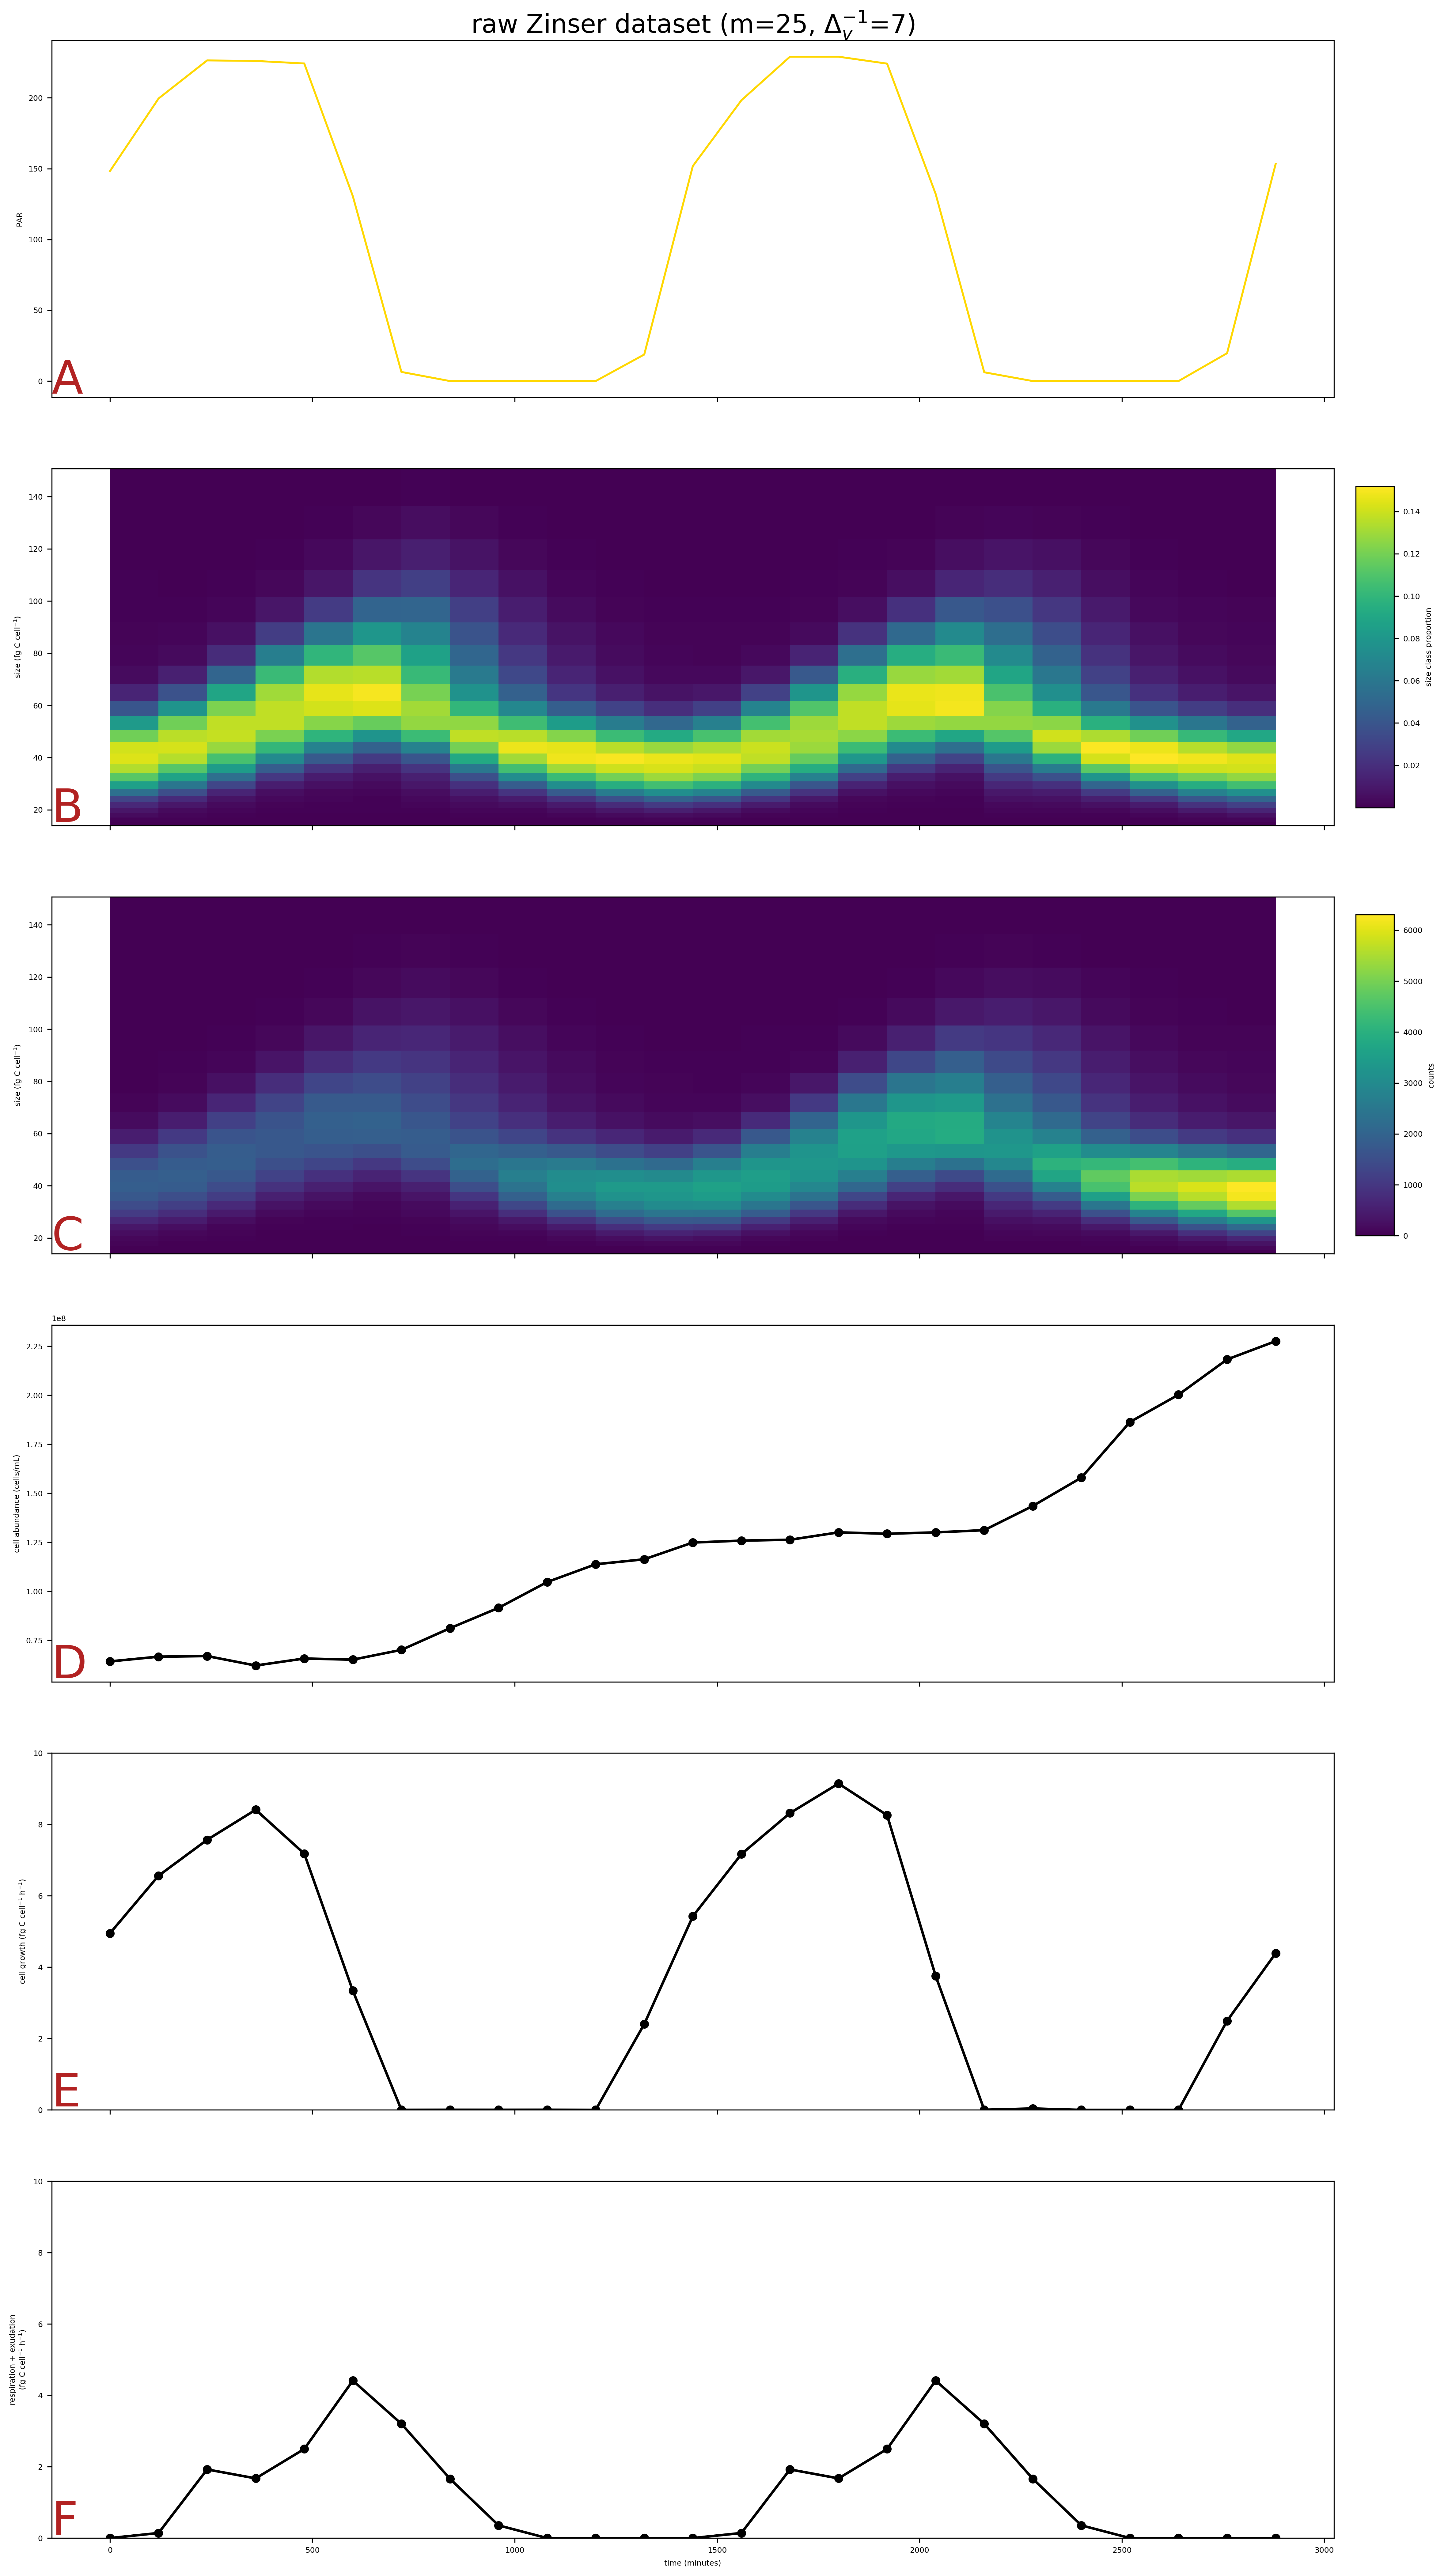

In [9]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 36

if show_data:
    for i,dataname in enumerate(data_gridded):
        if 'zinser' in dataname:
            nrows = 6

            v_min = data_gridded[dataname]['v_min']
            delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
            v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v)
            v_carbon = v*np.sqrt(2**(delta_v))

            fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(18,6*nrows))

            ax = axs[0]
            ax.set_title('raw '+desc[dataname], size=20)
            ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
            ax.set(ylabel='PAR')
            ax.text(0, 0.01, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

            ax = axs[1]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
            ax.text(0, 0.01, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

            ax = axs[2]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
            ax.text(0, 0.01, 'C', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
            
            ax = axs[3]
            pc = ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['abundance'], color='black',
                        marker='o', lw=2)
            ax.set(ylabel='cell abundance (cells/mL)')
            ax.text(0, 0.01, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
            
            ax = axs[4]
            ylim = (0, 10)
            prop = 'growth'
            with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                pc = ax.plot(data_gridded[dataname]['time'], np.maximum(0.0, nc[prop+'/'+prop][:]), color='black',
                             marker='o', lw=2)
            ax.set(ylabel=prop_labels[prop], ylim=ylim)
            ax.text(0, 0.01, 'E', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
            
            ax = axs[5]
            prop = 'respiration'
            with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                pc = ax.plot(data_gridded[dataname]['time'], np.maximum(0.0, nc[prop+'/'+prop][:]), color='black', marker='o', lw=2)
            ax.set(ylabel=prop_labels[prop], ylim=ylim)
            ax.set_xlabel('time (minutes)')
            ax.text(0, 0.01, 'F', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
#     if save_plots:
#         plt.savefig('figures/zinser_data.eps', bbox_inches='tight')
    plt.show()
    plt.close()
None

### Figure 2

Here we investigate why we get this consistent lag in the division timing in our models. By plotting the mean cell size at each time point against hourly division rate, we can see that cell size alone is not a great predictor of division rate for this dataset. However, when we look at cell size at t-6 hours and division rate at t, we see that there is quite a strong correlation which demonstrates that there may be some 6-hour "lag" process with respect to cell size and division (e.g. mitosis). This shows why we can have models get accurate daily rates even if the hourly rates are off.

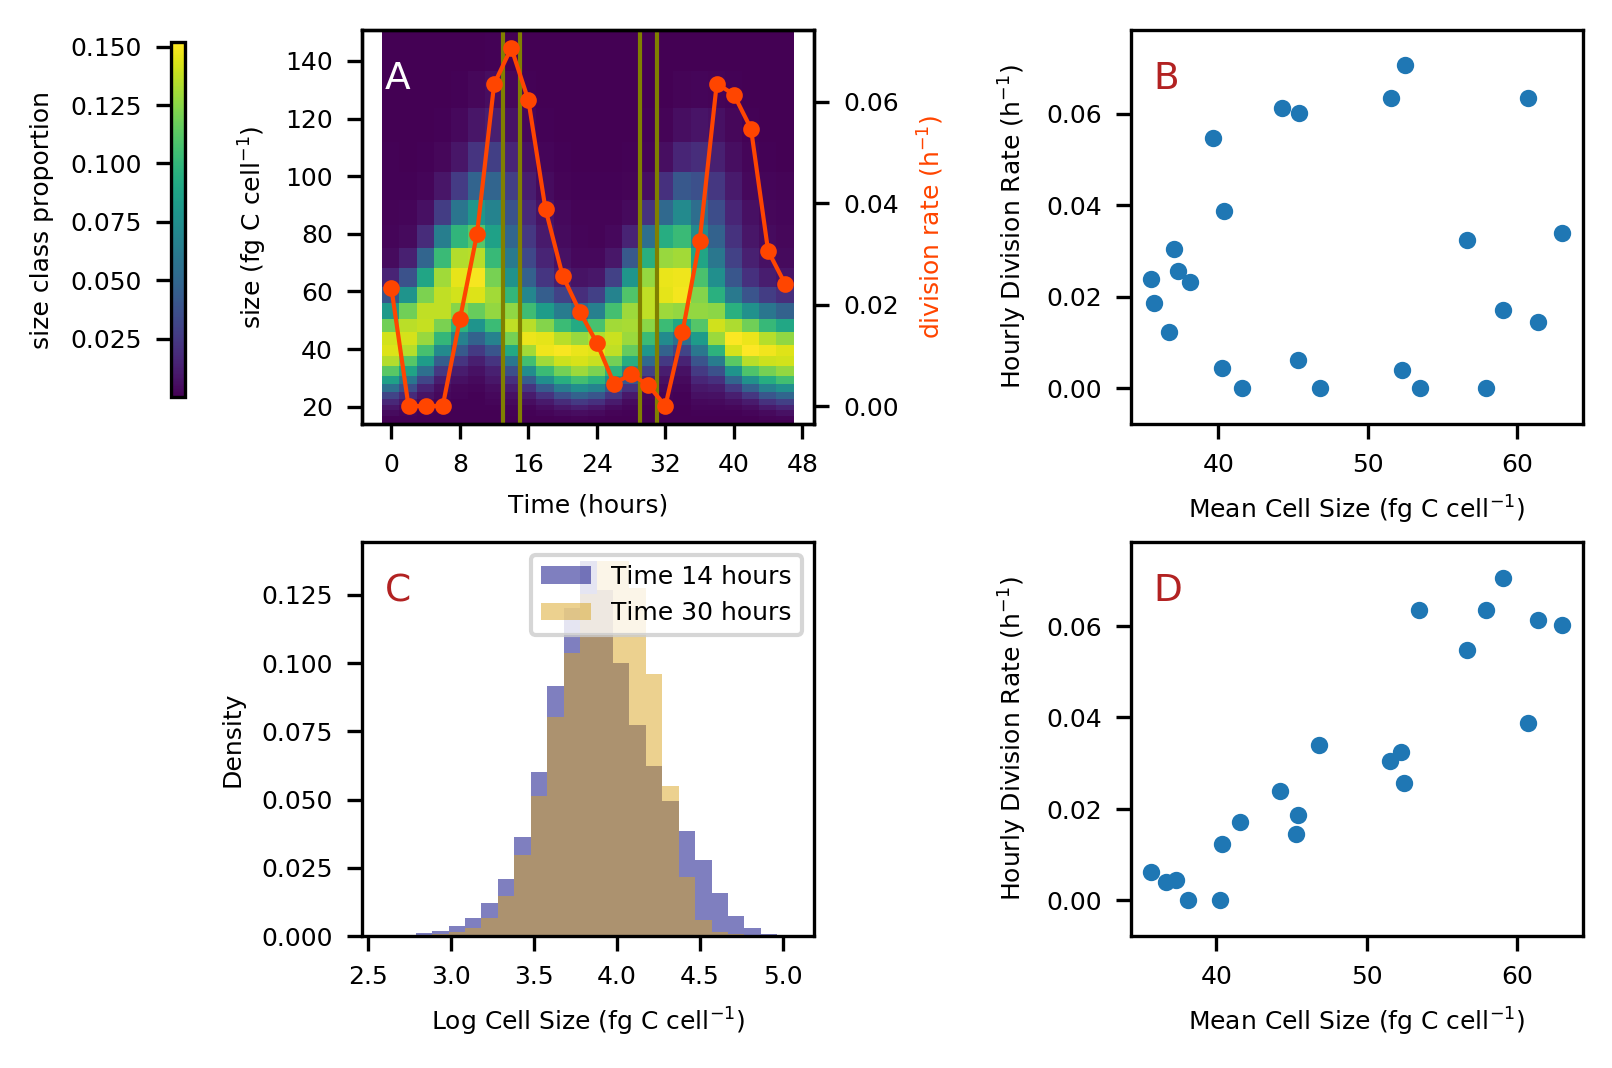

In [10]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'
    
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=2, bbox_to_anchor=(-0.45,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

dataname = 'zinser'

fontsize = 9

xtext = 0.05
ytext = 0.85

fig, axs = plt.subplots(2, 2, figsize=(5.25, 4))


# PSD with hourly division overlaid
ax = axs[0, 0]
pc = ax.pcolormesh(data_gridded[dataname]['time']/60, v, data_gridded[dataname]['w_obs'], shading='auto')
ax.set(ylabel='size ({})'.format(size_units))
#ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion', ticklocation='left')
# ax.set_title('Size Distribution over time Zinser dataset')
ax.set_xlabel('Time (hours)')
ax.set_xticks(np.arange(1, 50, 8))
ax.set_xticklabels(np.arange(0, 50, 8))

time1 = 14
time2 = 30
ylim = ax.get_ylim()
xlim = ax.get_xlim()
thickness = 1
ax.axvline(x=time1, ymin=0, ymax=1, lw=thickness, color='olive')
ax.axvline(x=time1+2, ymin=0, ymax=1, lw=thickness, color='olive')
ax.axvline(x=time2, ymin=0, ymax=1, lw=thickness, color='olive')
ax.axvline(x=time2+2, ymin=0, ymax=1, lw=thickness, color='olive')

with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
    prop = 'division'
    ax = ax.twinx()
    hourly_div = np.maximum(0.0, nc[prop+'/'+prop][:])
    ax.plot(nc[prop+'/time'][:], hourly_div,
            color='orangered', marker='o', lw=1, markersize=3)
    ax.set_ylabel(prop_labels[prop], color='orangered')

ax.text(xtext, ytext, 'A', transform = ax.transAxes, color='white', fontsize=fontsize)


# Hourly division rate vs. mean cell size
ax = axs[0, 1]
mean_size = []
for ii in range(len(data['zinser']['t_obs'])):
    mean_size.append(np.sum(data['zinser']['obs'][:, ii].flatten()*v))
ax.scatter(mean_size, hourly_div, s=10)
# ax.set_title('Hourly Division Rate vs. Mean Cell Size')
ax.set_xlabel('Mean Cell Size ({})'.format(size_units))
ax.set_ylabel('Hourly Division Rate (h$^{-1}$)')
ax.text(xtext, ytext, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)


# Hourly division rate vs. mean cell size with x-hour lag
ax = axs[1, 1]
lag = 6  # lag in hours
ax.scatter(mean_size[:-int(lag/2)], hourly_div[int(lag/2):], s=10)
# ax.set_title('Hourly Division Rate vs. Mean Cell Size: {}-hour lag'.format(lag))
ax.set_xlabel('Mean Cell Size ({})'.format(size_units))
ax.set_ylabel('Hourly Division Rate (h$^{-1}$)')
ax.text(xtext, ytext, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)


# Histograms showing similarity of PSD at two times with radically different division rates
ax = axs[1, 0]
space = (np.log(v[1]) - np.log(v[0]))
ax.bar(np.log(v), data_gridded['zinser']['w_obs'][:, int(time1/2)], width=space, color='navy',
       label='Time {} hours'.format(time1), alpha=0.5)
ax.bar(np.log(v), data_gridded['zinser']['w_obs'][:, int(time2/2)], width=space, color='goldenrod',
       label='Time {} hours'.format(time2), alpha=0.5)
ax.legend()
# ax.bar(v, data_gridded['zinser']['w_obs'][:, int(time2/2)])
# ax.set_title('Cell Size Distribution at Two Time Points')
ax.set_xlabel('Log Cell Size ({})'.format(size_units))
ax.set_ylabel('Density')
ax.text(xtext, ytext, 'C', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

plt.subplots_adjust(hspace=0.3, wspace=0.7)
# if save_plots:
#     plt.savefig('figures/division_vs_size.png', bbox_inches='tight')
plt.show()
plt.close()
# plt.subplots_adjust(wspace=0.2)  # set back to default
None

### Figure 3

The idea behind this figure is to show the model inference on the "big picture" daily population dynamics. We also show PSIS-LOO scores as a metric that balances model fit with model complexity. The green vertical lines indicate the "true" values of each daily quantity calculated from the data.

TODO: Add additional lines to indicate model results for current version of MPM as a baseline for comparison. Potentially also add Ek and model misfit.

In [11]:
# Function to calculate Pmax over a day from model output.
def get_pmax(model_results, v_diff, dataname='zinser'):
    
    dt_h = data[dataname]['dt']/60.0
    cell_count = np.asarray(model_results[dataname]['cell_count'])
    gamma_max = np.asarray(model_results[dataname]['gamma_max'])
    par = np.asarray(data[dataname]['E'])
    carbon_fixation = np.asarray(model_results[dataname]['growth_size_gain']/cell_count)
    Ek = np.asarray(model_results[dataname]['E_star'])

    if len(gamma_max.shape) == 2:
        gamma_max = np.max(gamma_max, axis=1)
        
    pmax = 0
    for ii in range(len(par)):
        if par[ii] > 0:
            pmax += carbon_fixation[:, ii] / (1 - np.exp(-par[ii]/Ek))
    
    return pmax/2

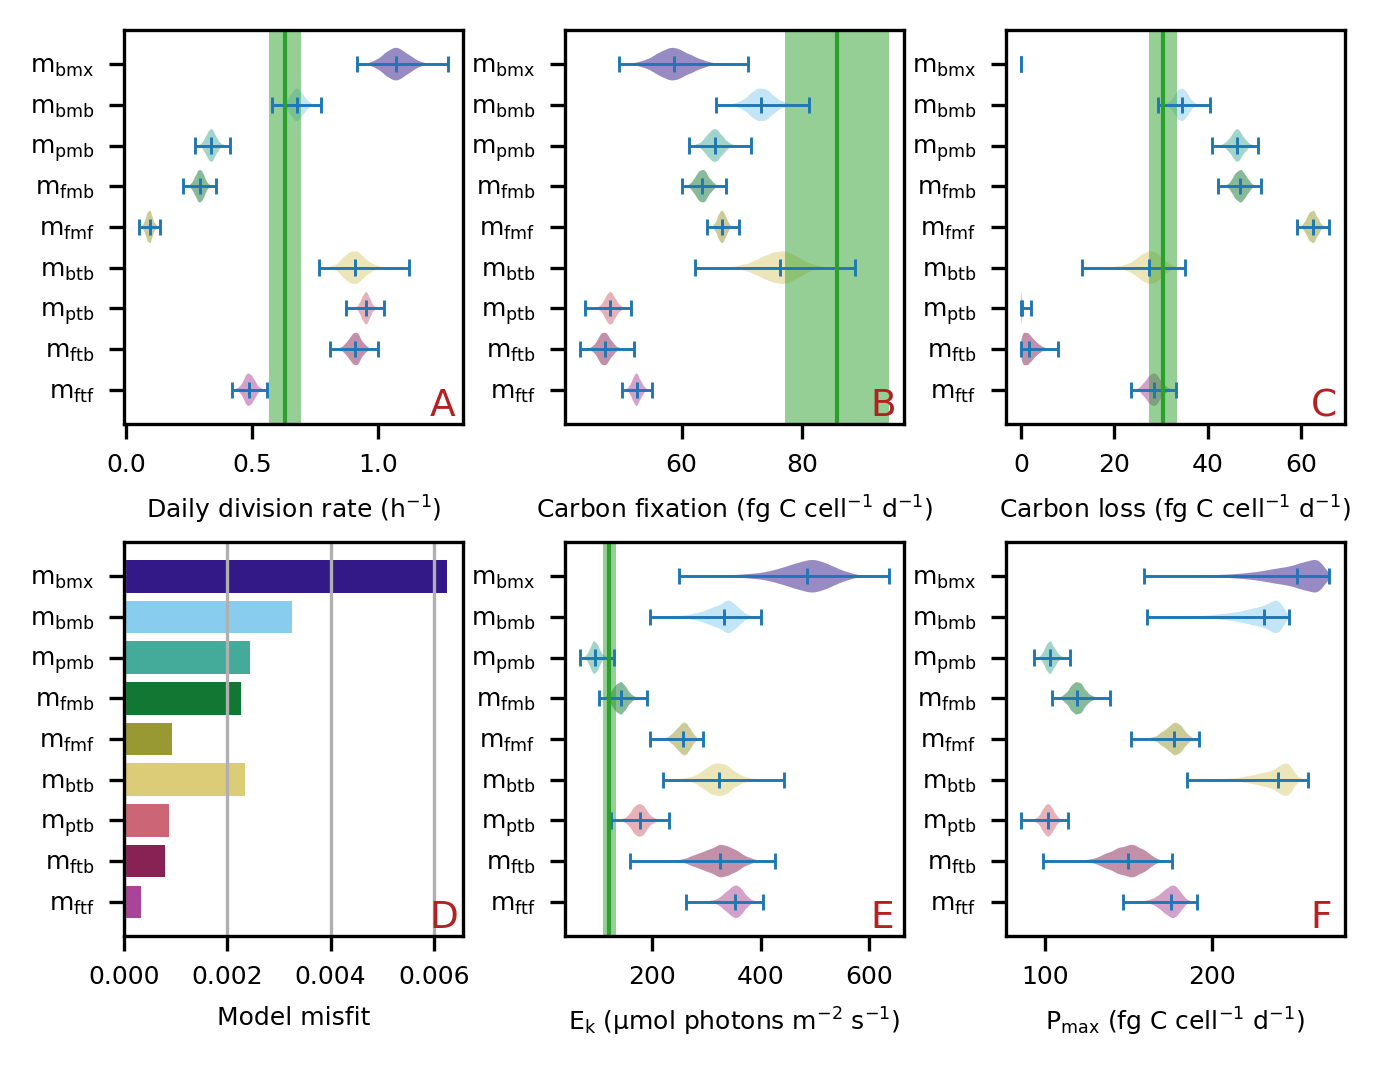

In [12]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 9

xtext = 0.9
ytext = 0.02

for dataname in ['zinser']:
    temp_mcmcs = {key: mcmcs[key] for key in mcmcs}
    num_mcmcs = len(temp_mcmcs)
    fig, axs = plt.subplots(2, 3, figsize=(5.25,4))
    
    
    # Daily division rates
    ax = axs[0, 0]
    widths = 0.8
    plot = ax.violinplot([temp_mcmcs[model][dataname]['divrate'] for model in temp_mcmcs],
                         showmedians=True, vert=False, widths=widths)
    linewidth = 0.7
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='Daily division rate (h$^{-1}$)')
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    if dataname in reference_values and 'divrate' in reference_values[dataname]:
#         ax.axvline(reference_values[dataname]['divrate'], color='tab:green', lw=1)
        ax.axvline(0.63, color='tab:green', lw=1)
        ax.axvspan(0.9*0.63, 1.1*0.63, facecolor='tab:green', alpha=0.5)
    ax.tick_params(grid_linestyle='')
    ax.text(xtext, ytext, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    # Daily growth/respiration
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    daily_props = {}

    for prop in ['growth', 'respiration']:

        daily_props[prop] = {}

        for model in temp_mcmcs:

            cell_count = temp_mcmcs[model][dataname]['cell_count']

            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))

            daily_prop = np.mean(plotprop, axis=1)*24

            daily_props[prop][model] = daily_prop

    for ax, prop in zip(axs[0, 1:], ('growth', 'respiration')):
        labels = {'growth': 'B', 'respiration': 'C'}
        if dataname == 'zinser':
            with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                true_prop = np.mean(np.maximum(0.0, nc[prop+'/'+prop][:]))*24

        title_labels = {'growth': 'carbon fixation', 'respiration': 'carbon loss'}
        xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
                  'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}

        plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop]],
                             showmedians=True, vert=False, widths=widths)
        plot['cbars'].set_linewidth(linewidth)
        plot['cmins'].set_linewidth(linewidth)
        plot['cmaxes'].set_linewidth(linewidth)
        plot['cmedians'].set_linewidth(linewidth)
        ax.set(xlabel=xlabels[prop])
        ii = 0
        for pc in plot['bodies']:
            pc.set_facecolor(colors[ii])
            pc.set_alpha(0.5)
            ii += 1
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        if 'zinser' in dataname:
            ax.axvline(true_prop, color='tab:green', lw=1)
            ax.axvspan(true_prop*0.9, true_prop*1.1, facecolor='tab:green', alpha=0.5)
        if dataname in reference_values and prop in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=1)
        ax.tick_params(grid_linestyle='')
        ax.text(xtext, ytext, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    # PSD misfit (MSE)
    ax = axs[1, 0]
#     model_mse = [np.mean((temp_mcmcs[model][dataname]['mod_obspos']
#                           - data_gridded[dataname]['w_obs'][None, :, :-1])**2) for model in temp_mcmcs]
#     ax.barh(np.arange(len(temp_mcmcs)),
#             model_mse,
#             color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
#     ax.invert_yaxis()
#     ax.text(xtext, ytext, 'D', transform=ax.transAxes, color='firebrick', fontsize=fontsize)
#     ax.set(yticks=np.arange(0,num_mcmcs),
#            yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
#     ax.set_xlabel('Mean squared error (MSE)')

    obs = data[dataname]['obs']
    num_bars = 1
    ee = np.zeros(len(temp_mcmcs))
    yticks = []
    yticklabels = []
    for ii, model in enumerate(temp_mcmcs):
        mod_mean = np.mean(temp_mcmcs[model][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        ee[ii] = np.mean(np.sum((mod_mean-obs)**2,axis=0))

    ax.barh(y=np.arange(len(temp_mcmcs)), width=ee, color=[colors_model[model] for model in temp_mcmcs])
    ax.grid(axis='x')
    ax.invert_yaxis()
    ax.text(xtext, ytext, 'D', transform=ax.transAxes, color='firebrick', fontsize=fontsize)
    ax.set(yticks=np.arange(0, num_mcmcs),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
    ax.set_xlabel('Model misfit')
    
    
    # Ek/Estar
    ax = axs[1, 1]
    linewidth = 0.7
    plot = ax.violinplot([temp_mcmcs[model][dataname]['E_star'] for model in temp_mcmcs],
                         showmedians=True, vert=False, widths=0.8)
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='E$_\mathrm{k}$ ($\mathrm{\mu}$mol photons m$^{-2}$ s$^{-1}$)')
    ax.axvline(120.97, color='tab:green', lw=1)
    ax.axvspan(0.9*120.97, 1.1*120.97, facecolor='tab:green', alpha=0.5)
    ax.tick_params(grid_linestyle='')
    
    ax.text(xtext, ytext, 'E', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    # Pmax
    ax = axs[1, 2]
    v_diff = v_carbon[1:] - v_carbon[:-1]
    linewidth = 0.7
    pmax = [get_pmax(temp_mcmcs[model], v_diff) for model in temp_mcmcs]
    plot = ax.violinplot(pmax, showmedians=True, vert=False, widths=0.8)
    plot['cbars'].set_linewidth(linewidth)
    plot['cmins'].set_linewidth(linewidth)
    plot['cmaxes'].set_linewidth(linewidth)
    plot['cmedians'].set_linewidth(linewidth)
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1, num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='P$_\max$ (fg C cell$^{-1}$ d$^{-1}$)')
#     ax.axvline(120.97, color='tab:green', lw=1)
#     ax.axvspan(0.9*120.97, 1.1*120.97, facecolor='tab:green', alpha=0.5)
    ax.tick_params(grid_linestyle='')
    
    ax.text(xtext, ytext, 'F', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    warnings.filterwarnings("ignore")
    if save_plots:
        plt.savefig('figures/zinser_daily.eps', format='eps', bbox_inches='tight')
    plt.show()
    plt.close()

### Figure 4

The idea of this figure is to look further under the hood of the model, and see what the model parameters are applying is happening on an hourly time scale. This reveals that the model has limitations on high-resolution time scales, most notably the lag in the timing of peak division.

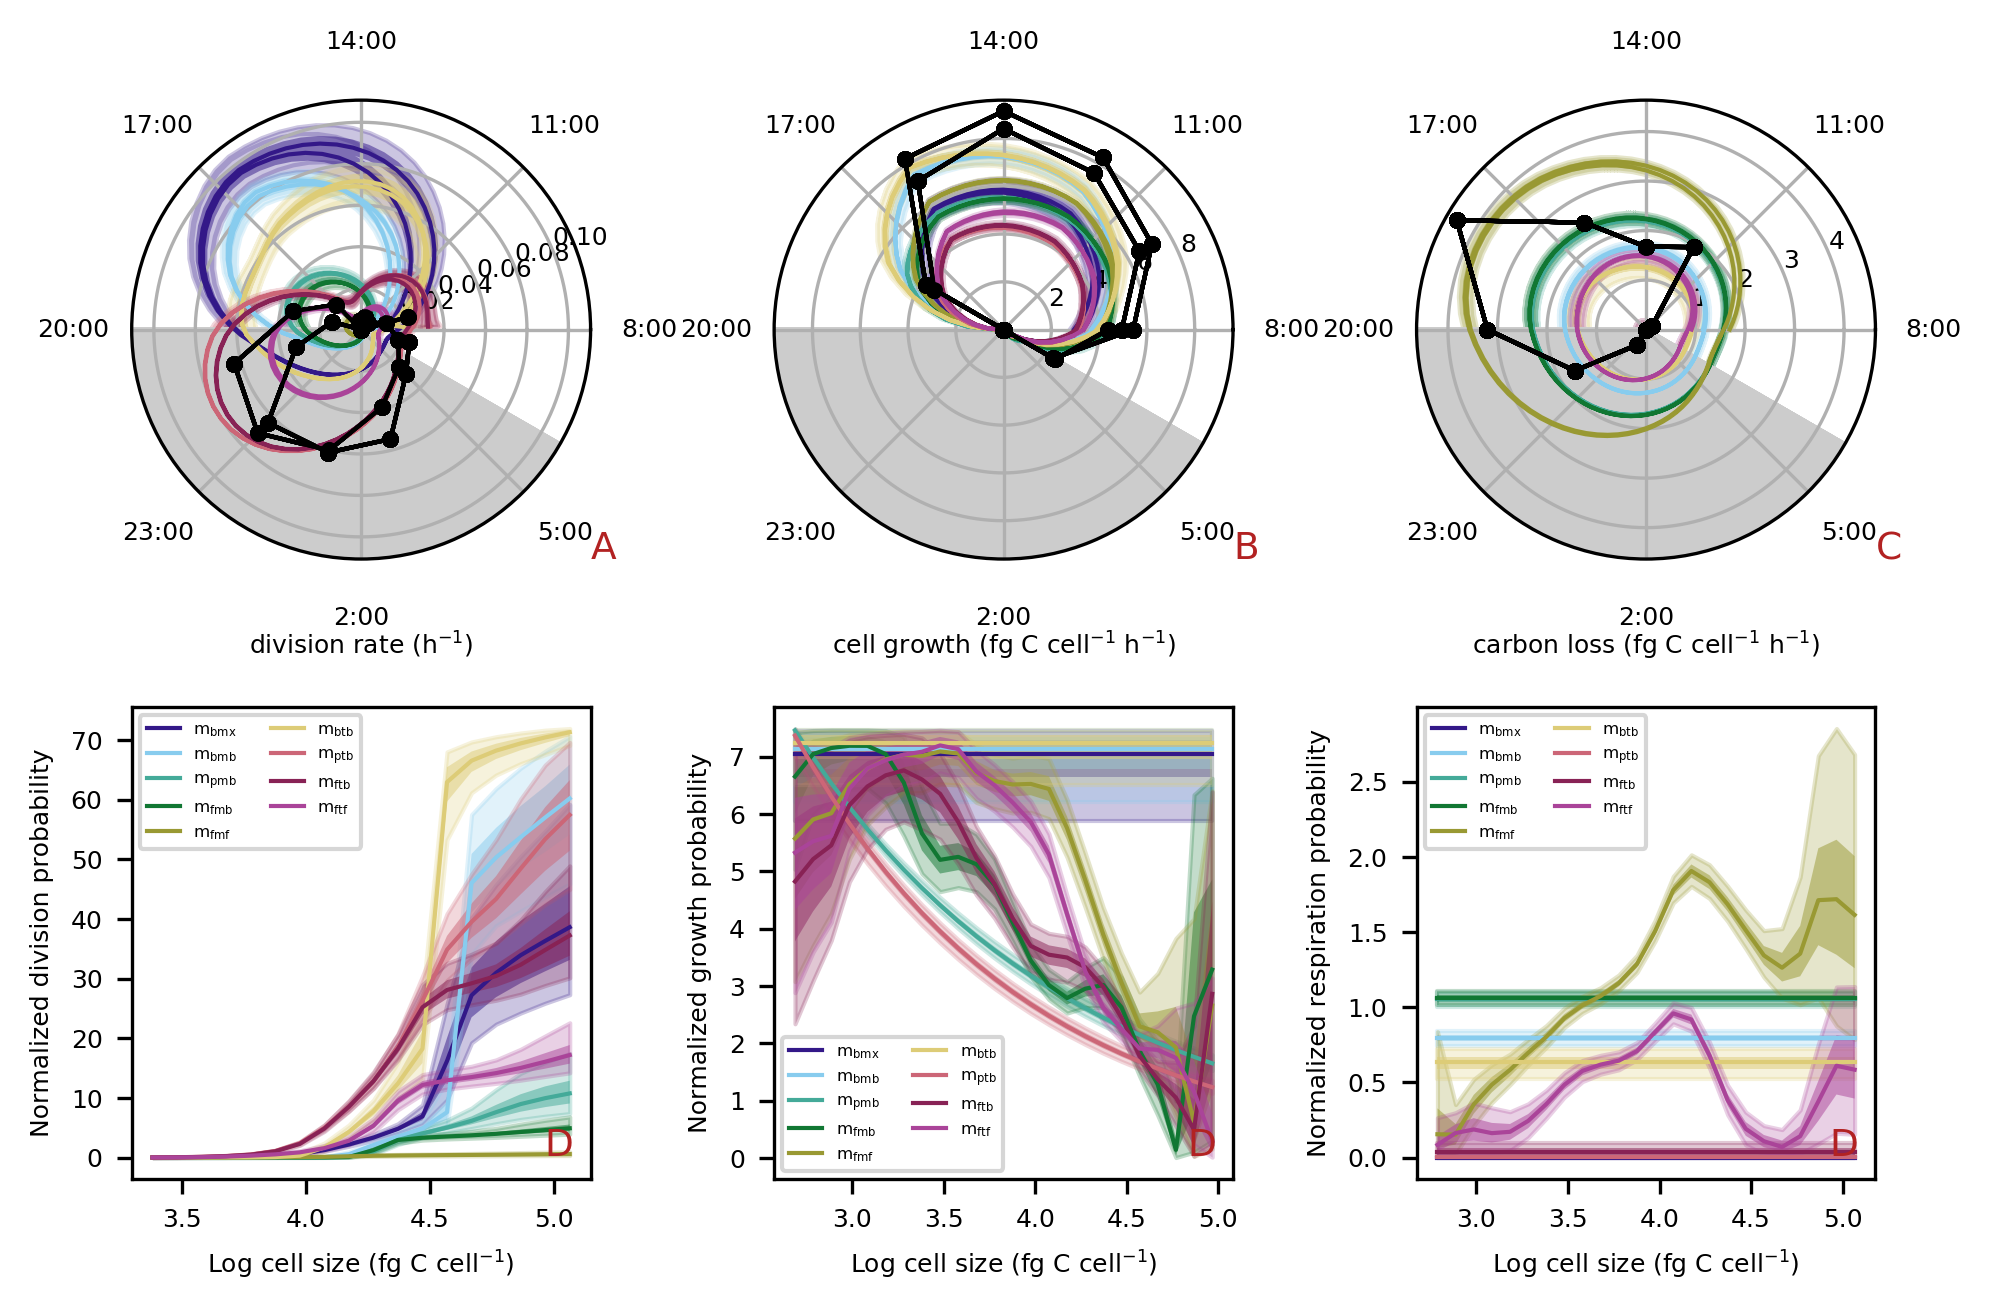

In [13]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'carbon loss ({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 9

xtext = 0.9
ytext = 0.05

xtext_pol = 1
ytext_pol = 0

for dataname in ['zinser']:
    fig = plt.figure(figsize=(7.5, 7.5))
    temp_mcmcs = {key: mcmcs[key] for key in mcmcs}
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    
    grids = gridspec.GridSpec(3, 1, figure=fig)
    
    
    # Hourly rate plots
    polar_grid = grids[0].subgridspec(1, 3)
    
    ii = 0
    mod_maxes = {}
    labels = {'division': 'A', 'growth': 'B', 'respiration': 'C'}
    for prop in ('division', 'growth', 'respiration'):
        ax = fig.add_subplot(polar_grid[ii], polar=True)
        
        for model in temp_mcmcs:
            cell_count = temp_mcmcs[model][dataname]['cell_count']
        
            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t * (np.pi/12.0)
            elif prop == 'division':
                plotprop = (np.log(cell_count[:,1:])-np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
                x = 0.5 * (t[1:] + t[:-1]) * (np.pi/12.0)
                temp = np.mean(plotprop, axis=0)
                mod_max = np.where(temp == np.max(temp[0:72]))[0][0]/3
                mod_maxes[model] = mod_max
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t * (np.pi/12.0)
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))
            qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)
            sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
            ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    ax.plot(nc[prop+'/time'][:]*(np.pi/12.0), np.maximum(0.0, nc[prop+'/'+prop][:]),
                            color='black', marker='o', lw=1, markersize=3)
                    if prop == 'division':
                        temp = np.maximum(0.0, nc[prop+'/'+prop][:])
                        true_max = np.where(temp == np.max(temp[0:12]))[0][0]*2
            ax.set_ylim(bottom=0.0)
            ax.set_xlabel(prop_labels[prop], labelpad=0)
            ax.set_xticklabels(['{:d}:{:02d}'.format((int(t*(12/np.pi)+8)%24), int(60*(t*(12/np.pi)%1.0)))
                                for t in ax.get_xticks()])
            # darkness from 20:00 to 6:00
            # ymax > 1 needed because it's a polar plot
            ax.axvspan(720*(np.pi/720.0), (1440-120)*(np.pi/720.0), color='0.8', ymax=10, zorder=1)
            ax.grid(True)
#         if ii == 0:
#             ax.set_title('Hourly population dynamics' + '\n' + desc[dataname])
        ax.text(xtext_pol, ytext_pol, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
        ii += 1
    
    reg_grid = grids[1].subgridspec(1, 3)
    
    
    # Division Offset
#     ax = fig.add_subplot(reg_grid[0])
#     div_lag = [true_max - mod_maxes[model] for model in temp_mcmcs]
#     ax.barh(np.arange(len(temp_mcmcs)),
#                     div_lag,
#                     color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
#     ax.invert_yaxis()
# #     ax.set_title('Division offset: peak-to-peak (h)')
#     ax.set(yticks=np.arange(0,num_mcmcs),
#            yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
#            xlabel='Division offset (h)')
#     ax.text(xtext, ytext, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    # Division vs. size
    ax = fig.add_subplot(reg_grid[0])
    for model in temp_mcmcs:
        div_size = temp_mcmcs[model][dataname]['delta']
        x = np.log(v_carbon[-(div_size.shape[1]):])
        qq = np.percentile(div_size, q=(5,25,50,75,95), axis=0)
        sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
        ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
        ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
    ax.set_xlabel('Log cell size (fg C cell$^{-1}$)')
    ax.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs], loc='best', ncol=2, fontsize=4)
    ax.set_ylabel('Normalized division probability')
    ax.text(xtext, ytext, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    # Carbon fixation vs. size
    ax = fig.add_subplot(reg_grid[1])
    m = temp_mcmcs['m4']['zinser']['w_ini'].shape[1]
    for model in temp_mcmcs:
        gamma_max = temp_mcmcs[model][dataname]['gamma_max']
        if len(gamma_max.shape) == 1:
            growth_size = np.tile(gamma_max, m-1).reshape(m-1, -1).T
        else:
            growth_size = gamma_max
        if 'exponent_gamma' in temp_mcmcs[model][dataname].keys():
            exponent_gamma = temp_mcmcs[model][dataname]['exponent_gamma']
            
            # No model output has a positive exponent_gamma, so we can assume negative
            sizelim_gamma = ((v_carbon[None, :-1]**exponent_gamma[:, None]) /
                             (v_carbon[None, 0]**exponent_gamma[:, None]))
            growth_size = growth_size * sizelim_gamma

        x = np.log(v_carbon[:-1])
        qq = np.percentile(growth_size, q=(5,25,50,75,95), axis=0)
        sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
        ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
        ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
    ax.set_xlabel('Log cell size (fg C cell$^{-1}$)')
    ax.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs], loc='best', ncol=2, fontsize=4)
    ax.set_ylabel('Normalized growth probability')
    ax.text(xtext, ytext, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    # Carbon loss vs. size
    ax = fig.add_subplot(reg_grid[2])
    m = temp_mcmcs['m4']['zinser']['w_ini'].shape[1]
    for model in temp_mcmcs:
        if model == 'm2':
            rho_max = np.zeros(6000)
        else:
            rho_max = temp_mcmcs[model][dataname]['rho_max']
        if len(rho_max.shape) == 1:
            resp_size = np.tile(rho_max, m-1).reshape(m-1, -1).T
        else:
            resp_size = rho_max
        x = np.log(v_carbon[1:])
        qq = np.percentile(resp_size, q=(5,25,50,75,95), axis=0)
        sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
        ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
        ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
    ax.set_xlabel('Log cell size (fg C cell$^{-1}$)')
    ax.legend([desc_model[model].replace(',',',\n') for model in temp_mcmcs], loc='upper left', ncol=2, fontsize=4)
    ax.set_ylabel('Normalized respiration probability')
    ax.text(xtext, ytext, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    
    bottom_grid = grids[2].subgridspec(1, 3)
    
    
    
    
    plt.subplots_adjust(hspace=0.3, wspace=0.4)
    warnings.filterwarnings('ignore')
    if save_plots:
        plt.savefig('figures/zinser_hourly.eps', format='eps', bbox_inches='tight')
    plt.show()
    plt.close()

### Figure 5

Now we apply some of these models to SeaFlow data and examine the results.

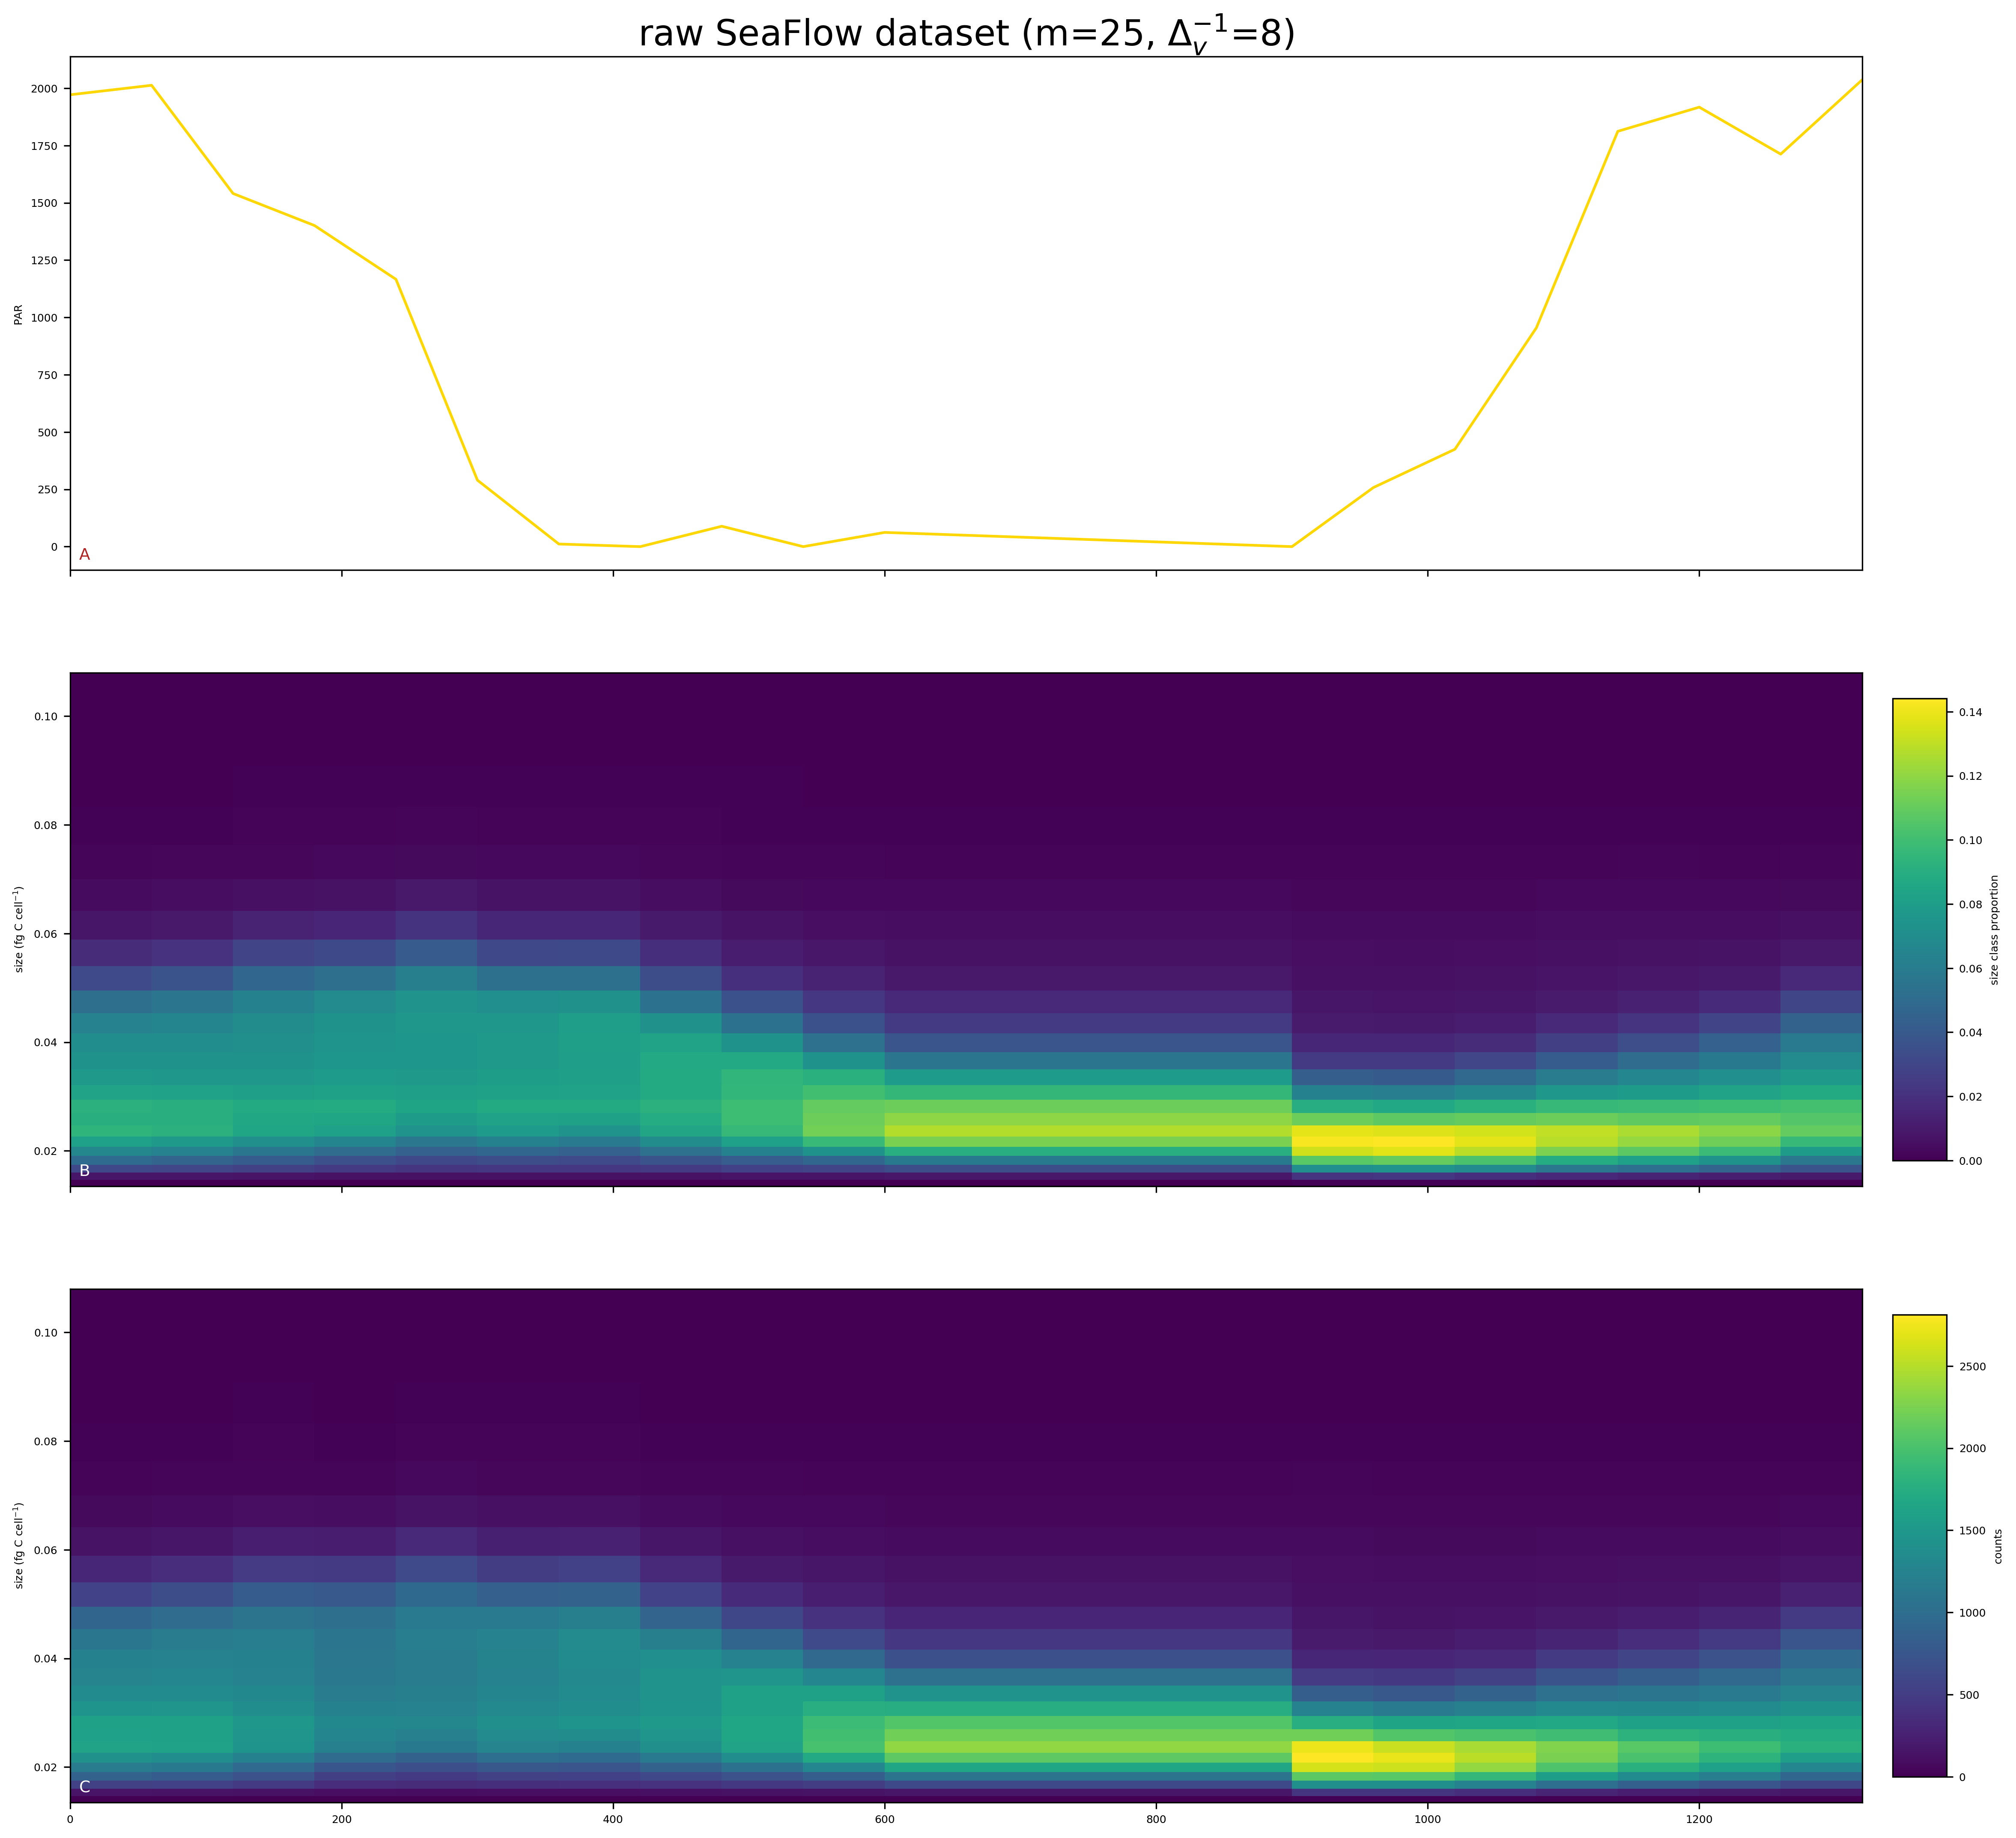

In [14]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

if show_data:
    for i,dataname in enumerate(data_gridded):
        if 'seaflow' in dataname:
            nrows = 3

            v_min = data_gridded[dataname]['v_min']
            delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
            v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

            fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(18,6*nrows))

            ax = axs[0]
            ax.set_title('raw '+desc[dataname], size=20)
            ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
            ax.set(ylabel='PAR')
            ax.text(0.005, 0.02, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

            ax = axs[1]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
            ax.text(0.005, 0.02, 'B', transform = ax.transAxes, color='white', fontsize=fontsize)

            ax = axs[2]
            pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
            ax.set(ylabel='size ({})'.format(size_units))
            #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
            add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
            ax.text(0.005, 0.02, 'C', transform = ax.transAxes, color='white', fontsize=fontsize)
    if save_plots:
        plt.savefig('figures/seaflow_data.eps', format='eps', bbox_inches='tight')
    plt.show()
    plt.close()
None

In [15]:
mcmcs.keys()

dict_keys(['m2', 'm4', 'm12u', 'm15', 'm16', 'm4s6', 'm12us6', 'm15s6', 'm16s6'])

In [16]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 36

for dataname in ['seaflow']:
    for param in ('divrate',):
#         temp_mcmcs = {key: mcmcs[key] for key in mcmcs if 's6' in key}
        temp_mcmcs = mcmcs.copy()
        num_mcmcs = len(temp_mcmcs)
        fig, axs = plt.subplots(2, 2, figsize=(32,4*num_mcmcs))
        
        ax = axs[0, 0]
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        plot = ax.violinplot([temp_mcmcs[model][dataname][param] for model in temp_mcmcs],
                             showmedians=True, vert=False)
        ii = 0
        for pc in plot['bodies']:
            pc.set_facecolor(colors_model[list(models)[ii]])
            pc.set_alpha(0.5)
            ii += 1
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        ax.text(0.005, 0.92, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

        ax = axs[0, 1]
        ax.barh(np.arange(len(temp_mcmcs)),
                    [float(loos[model][dataname]) for model in temp_mcmcs],
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
        ax.invert_yaxis()
        if 'zinser' in dataname:
            ax.set_xlim(-1359000, -1355000)
        elif 'seaflow' in dataname:
            ax.set_xlim(-856000, -852000)
        ax.set_title('PSIS-LOO Score by model for {} dataset'.format(dataname))
        ax.set(yticks=np.arange(0,num_mcmcs),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        ax.text(0.005, 0.92, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
        dt_h = data[dataname]['dt']/60.0
        
        daily_props = {}
        
        for prop in ['growth', 'respiration']:
            
            daily_props[prop] = {}
            
            for model in temp_mcmcs:

                cell_count = temp_mcmcs[model][dataname]['cell_count']

                if prop == 'growth':
                    plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                    x = t
                elif prop == 'respiration':
                    plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                    x = t
                else:
                    raise ValueError('Unknown prop "{}".'.format(prop))
                
                daily_prop = np.mean(plotprop, axis=1)*24
                
                daily_props[prop][model] = daily_prop
        
        labels = {'growth': 'C', 'respiration': 'D'}
                
        for ax, prop in zip(axs[1, :], ('growth', 'respiration')):
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    true_prop = np.mean(np.maximum(0.0, nc[prop+'/'+prop][:]))*24
            
            title_labels = {'growth': 'carbon fixation', 'respiration': 'carbon loss'}
            xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
                      'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}
            
            ax.set_title('{} for {}'.format('Daily {}'.format(title_labels[prop]), desc[dataname]))
            plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop]],
                                 showmedians=True, vert=False)
            ax.set(xlabel=xlabels[prop])
            ii = 0
            for pc in plot['bodies']:
                pc.set_facecolor(colors_model[list(models)[ii]])
                pc.set_alpha(0.5)
                ii += 1
            ax.invert_yaxis()
            ax.grid(axis='x')
            ax.set(yticks=np.arange(1,num_mcmcs+1),
                   yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
            if 'zinser' in dataname:
                ax.axvline(true_prop, color='tab:green', lw=3)
            if dataname in reference_values and prop in reference_values[dataname]:
                ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
            ax.text(0.005, 0.92, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)

NameError: name 'loos' is not defined

In [ ]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'
    
prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 36

labels = {'growth': 'A', 'division': 'C', 'respiration': 'E'}

for dataname in ['seaflow']:
    fig = plt.figure(figsize=(9*2.5, 9*3))
#     temp_mcmcs = {key: mcmcs[key] for key in mcmcs if 's6' in key}
    temp_mcmcs = mcmcs.copy()
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0 + 6
    dt_h = data[dataname]['dt']/60.0
    
    grids = gridspec.GridSpec(1, 2, figure=fig)
    
    polar_grid = grids[0].subgridspec(3, 1)
    
    ii = 0
    mod_maxes = {}
    for prop in ('growth', 'division', 'respiration'):
        ax = fig.add_subplot(polar_grid[ii], polar=True)
        
        for model in temp_mcmcs:
            cell_count = temp_mcmcs[model][dataname]['cell_count']
        
            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t * (np.pi/12.0)
            elif prop == 'division':
                plotprop = (np.log(cell_count[:,1:])-np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
                x = 0.5 * (t[1:] + t[:-1]) * (np.pi/12.0)
                temp = np.mean(plotprop, axis=0)
                mod_max = np.where(temp == np.max(temp[0:72]))[0][0]/3
                mod_maxes[model] = mod_max
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t * (np.pi/12.0)
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))
            qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)
            sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
            ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=2)
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    ax.plot(nc[prop+'/time'][:]*(np.pi/12.0), np.maximum(0.0, nc[prop+'/'+prop][:]),
                            color='black', marker='o', lw=2)
                    if prop == 'division':
                        temp = np.maximum(0.0, nc[prop+'/'+prop][:])
                        true_max = np.where(temp == np.max(temp[0:12]))[0][0]*2
            ax.set_ylim(bottom=0.0)
            ax.set_ylabel(prop_labels[prop], labelpad=40)
            ax.set_xticklabels(['{:d}:{:02d}'.format((int(t*(12/np.pi)+8)%24), int(60*(t*(12/np.pi)%1.0)))
                                for t in ax.get_xticks()])
            # darkness from 20:00 to 6:00
            # ymax > 1 needed because it's a polar plot
            ax.axvspan(720*(np.pi/720.0), (1440-120)*(np.pi/720.0), color='0.8', ymax=10, zorder=1)
            ax.grid(True)
        if ii == 0:
            ax.set_title('Hourly population dynamics' + '\n' + desc[dataname])
        ax.text(1, 0.01, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
        ii += 1
    
    reg_grid = grids[1].subgridspec(3, 1)
    
    param = 'E_star'
    ax = fig.add_subplot(reg_grid[0])
    plot = ax.violinplot([temp_mcmcs[model][dataname][param] for model in temp_mcmcs],
                             showmedians=True, vert=False)
    ii = 0
    for pc in plot['bodies']:
        pc.set_facecolor(colors_model[list(models)[ii]])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
    ax.set_title(r'$E_k$')
    ax.set_xlabel(r'$\mu$mol quanta m$^{-3}$ s$^{-1}$')
    if dataname in reference_values and param in reference_values[dataname]:
        ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
    ax.text(0.93, 0.01, 'B', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
        
    ax = fig.add_subplot(reg_grid[1])
    div_lag = [true_max - mod_maxes[model] for model in temp_mcmcs]
    ax.barh(np.arange(len(temp_mcmcs)),
                    div_lag,
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
    ax.invert_yaxis()
    ax.set_title('Division offset: peak-to-peak (h)')
    ax.set(yticks=np.arange(0,num_mcmcs),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='Division offset (h)')
    ax.text(0.93, 0.01, 'D', transform = ax.transAxes, color='firebrick', fontsize=fontsize)

### Figure 6

Now we examine the fit to the SeaFlow data of two models: one without time-dependent division that does the best on daily rate estimation, and one with time-dependent division that does the best on hourly rate estimates.

In [ ]:
colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

seaflow_models = ['m4', 'm15s6']

temp_mcmcs = {model: mcmcs.copy()[model] for model in seaflow_models}

fontsize = 36

labels = ['A', 'C', 'B', 'D']

for dataname in ['seaflow']:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
    
    fig,axs = plt.subplots(2, len(seaflow_models), sharex=True, figsize=(24,2*8))
    
    plt.subplots_adjust(wspace=0.4)
    
    ii = 0
    jj = 0

    for model, mcmc in temp_mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        axs[0, ii].set_title(desc_model[model] + '\n' + desc[dataname])

        ax = axs[0, ii]
        ax.set(ylabel='size ({})'.format(size_units),
               title='size distribution model {} posterior'.format(desc_model[model])
               + '\n' + desc[dataname])
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, res_sum1,norm=norm, shading='auto')
        ax.text(0.01, 0.92, labels[jj], transform = ax.transAxes, color='white', fontsize=fontsize)
        
        jj += 1

        ax = axs[1, ii]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, diff,norm=norm_diff, cmap='PiYG', shading='auto')
        ax.set(ylabel='size ({})'.format(size_units), title='model {} data misfit'.format(desc_model[model]))
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        ax.text(0.01, 0.92, labels[jj], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
        
        ii += 1
        jj += 1
    if save_plots:
        plt.savefig('figures/seaflow_model_fit.eps', format='eps', bbox_inches='tight')
    plt.show()
    plt.close()

### Figure 7

This figure aims to compare the daily and hourly rate parameters of fitting two different models to the SeaFlow data: one without time-dependent division that does the best on daily rate estimation, and one with time-dependent division that does the best on hourly rate estimates.

In [ ]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

seaflow_models = ['m4', 'm15s6']

labels = ['A', 'C', 'E', 'B', 'D', 'F']

fontsize = 36

jj = 0

for dataname in ['seaflow']:
    
    temp_mcmcs = mcmcs.copy()
    
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14*2,10*3), sharex=False)
    
    for param in ('divrate',):
#         temp_mcmcs = {key: mcmcs[key] for key in mcmcs if 's6' in key}
        temp_mcmcs = mcmcs.copy()
        num_mcmcs = len(seaflow_models)
        
        ax = axs[0, 0]
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        plot = ax.violinplot([temp_mcmcs[model][dataname][param] for model in seaflow_models],
                             showmedians=True, vert=False)
        colors = [colors_model[model] for model in seaflow_models]
        ii = 0
        for pc in plot['bodies']:
            pc.set_facecolor(colors[ii])
            pc.set_alpha(0.5)
            ii += 1
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in seaflow_models])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        ax.text(0.02, 0.02, labels[jj], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
        ax.set_xlabel(r'Daily Division Rate (d$^{-1}$)')
        
        jj += 1
        
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    daily_props = {}

    for prop in ['growth', 'respiration']:

        daily_props[prop] = {}

        for model in seaflow_models:

            cell_count = temp_mcmcs[model][dataname]['cell_count']

            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))

            daily_prop = np.mean(plotprop, axis=1)*24

            daily_props[prop][model] = daily_prop
    
    for ax, prop in zip(axs[1:, 0], ('growth', 'respiration')):
        if dataname == 'zinser':
            with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                true_prop = np.mean(np.maximum(0.0, nc[prop+'/'+prop][:]))*24

        title_labels = {'growth': 'carbon fixation', 'respiration': 'carbon loss'}
        xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
                  'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}

        ax.set_title('{} for {}'.format('Daily {}'.format(title_labels[prop]), desc[dataname]))
        plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop]],
                             showmedians=True, vert=False)
        ax.set(xlabel=xlabels[prop])
        ii = 0
        for pc in plot['bodies']:
            pc.set_facecolor(colors[ii])
            pc.set_alpha(0.5)
            ii += 1
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in seaflow_models])
        if 'zinser' in dataname:
            ax.axvline(true_prop, color='tab:green', lw=3)
        if dataname in reference_values and prop in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        ax.text(0.02, 0.02, labels[jj], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
        
        jj += 1
    
    for model in seaflow_models:

        cell_count = mcmcs[model][dataname]['cell_count']
        
        for ax, prop in zip(axs[:, 1], ('division', 'growth', 'respiration')):

            if prop == 'growth':
                plotprop = mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t
            elif prop == 'division':
                plotprop = (np.log(cell_count[:,1:])-np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
                x = 0.5 * (t[1:] + t[:-1])
            elif prop == 'respiration':
                plotprop = mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))
            
            qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)

            sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
            ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=2, label=desc_model[model])

            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    ax.plot(nc[prop+'/time'][:], np.maximum(0.0, nc[prop+'/'+prop][:]), color='black', marker='o', lw=2)
            
            ax.set_ylim(bottom=0.0)
            ax.set_xlim((0, t[-1]))
            ax.set(ylabel=prop_labels[prop])
            ax.grid(True)
            ax.legend(loc='lower right')
            ax.set_title('Hourly {} rate for SeaFlow dataset'.format(prop))
            ax.set(xticks = np.arange(0,t[-1],6), xlabel='time since start of experiment (h)')
            if jj < 6:
                ax.text(0.02, 0.02, labels[jj], transform = ax.transAxes, color='firebrick', fontsize=fontsize)

                jj += 1
                
        if axs[-1, 1].get_ylim()[-1] < axs[1, 1].get_ylim()[-1]:
            axs[-1, 1].set_ylim(top=axs[1, 1].get_ylim()[-1])
    if save_plots:
        plt.savefig('figures/seaflow_parameters.eps', format='eps', bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
if 'size_units' not in globals():
    size_units = 'fg C cell$^{-1}$'

prop_labels = {
    'growth':'cell growth ({} h$^{{-1}}$)'.format(size_units),
    'division':'division rate (h$^{-1}$)',
    'respiration':'respiration + exudation\n({} h$^{{-1}}$)'.format(size_units),
}

fontsize = 9

for dataname in ['zinser']:
    fig = plt.figure(figsize=(7.5, 7.5))
    temp_mcmcs = {key: mcmcs[key] for key in mcmcs}
    num_mcmcs = len(temp_mcmcs)
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])/60.0
    dt_h = data[dataname]['dt']/60.0
    
    grids = gridspec.GridSpec(1, 3, figure=fig)
    
    
    # Daily parameter plots
    left_grid = grids[0].subgridspec(3,1)
    
    ax = fig.add_subplot(left_grid[0])
    plot = ax.violinplot([temp_mcmcs[model][dataname]['divrate'] for model in temp_mcmcs],
                         showmedians=True, vert=False)
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
    ax.axvline(0.63, color='tab:green')
    ax.axvspan(0.9*0.63, 1.1*0.63, facecolor='tab:green', alpha=0.5)
    ax.text(0.02, 0.9, 'A', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    daily_props = {}

    for prop in ['growth', 'respiration']:

        daily_props[prop] = {}

        for model in temp_mcmcs:

            cell_count = temp_mcmcs[model][dataname]['cell_count']

            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))

            daily_prop = np.mean(plotprop, axis=1)*24

            daily_props[prop][model] = daily_prop

    for ii, prop in zip([1, 2], ('growth', 'respiration')):
        labels = {'growth': 'D', 'respiration': 'G'}
        if dataname == 'zinser':
            with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                true_prop = np.mean(np.maximum(0.0, nc[prop+'/'+prop][:]))*24
        
        ax = fig.add_subplot(left_grid[ii])

        xlabels = {'growth': 'Carbon fixation ({} d$^{{-1}}$)'.format(size_units),
                  'respiration': 'Carbon loss ({} d$^{{-1}}$)'.format(size_units)}

        plot = ax.violinplot([daily_props[prop][model] for model in daily_props[prop]],
                             showmedians=True, vert=False)
        ax.set(xlabel=xlabels[prop])
        ii = 0
        for pc in plot['bodies']:
            pc.set_facecolor(colors[ii])
            pc.set_alpha(0.5)
            ii += 1
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1),
               yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
        if 'zinser' in dataname:
            ax.axvline(true_prop, color='tab:green')
            ax.axvspan(0.9*true_prop, 1.1*true_prop, facecolor='tab:green', alpha=0.5)
        if dataname in reference_values and prop in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green')
            ax.asvspan(reference_values[dataname][param]*0.9, reference_values[dataname][param]*1.1,
                       facecolor='tab:green', alpha=0.5)
        ax.text(0.02, 0.9, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    
    # Hourly parameter plots
    polar_grid = grids[1].subgridspec(3, 1)
    
    ii = 0
    mod_maxes = {}
    labels = {'division': 'B', 'growth': 'E', 'respiration': 'H'}
    for prop in ('division', 'growth', 'respiration'):
        ax = fig.add_subplot(polar_grid[ii], polar=True)
        
        for model in temp_mcmcs:
            cell_count = temp_mcmcs[model][dataname]['cell_count']
        
            if prop == 'growth':
                plotprop = temp_mcmcs[model][dataname]['growth_size_gain']/cell_count/dt_h
                x = t * (np.pi/12.0)
            elif prop == 'division':
                plotprop = (np.log(cell_count[:,1:])-np.log(cell_count[:,:-1]))/(t[1:]-t[:-1])
                x = 0.5 * (t[1:] + t[:-1]) * (np.pi/12.0)
                temp = np.mean(plotprop, axis=0)
                mod_max = np.where(temp == np.max(temp[0:72]))[0][0]/3
                mod_maxes[model] = mod_max
            elif prop == 'respiration':
                plotprop = temp_mcmcs[model][dataname]['resp_size_loss']/cell_count/dt_h
                x = t * (np.pi/12.0)
            else:
                raise ValueError('Unknown prop "{}".'.format(prop))
            qq = np.percentile(plotprop, q=(5,25,50,75,95), axis=0)
            sc = ax.fill_between(x, qq[0,:], qq[-1,:], alpha=0.25, color=colors_model[model])
            ax.fill_between(x, qq[1,:], qq[-2,:], alpha=0.5, facecolor=sc.get_facecolor()[0])
            ax.plot(x, qq[2,:], color=sc.get_facecolor()[0][:-1], lw=1)
            if dataname == 'zinser':
                with nc4.Dataset('data/zinser_growthdivresp.nc') as nc:
                    ax.plot(nc[prop+'/time'][:]*(np.pi/12.0), np.maximum(0.0, nc[prop+'/'+prop][:]),
                            color='black', marker='o', lw=1, markersize=3)
                    if prop == 'division':
                        temp = np.maximum(0.0, nc[prop+'/'+prop][:])
                        true_max = np.where(temp == np.max(temp[0:12]))[0][0]*2
            ax.set_ylim(bottom=0.0)
#             ax.set_ylabel(prop_labels[prop])
            ax.set_xticklabels(['{:d}:{:02d}'.format((int(t*(12/np.pi)+8)%24), int(60*(t*(12/np.pi)%1.0)))
                                for t in ax.get_xticks()])
            # darkness from 20:00 to 6:00
            # ymax > 1 needed because it's a polar plot
            ax.axvspan(720*(np.pi/720.0), (1440-120)*(np.pi/720.0), color='0.8', ymax=10, zorder=1)
            ax.grid(True)
        ax.text(0.02, 0.9, labels[prop], transform = ax.transAxes, color='firebrick', fontsize=fontsize)
        ii += 1

    
    right_grid = grids[2].subgridspec(3, 1)
    
    # Right hand column of plots
    ax = fig.add_subplot(right_grid[0])
    
    div_lag = [true_max - mod_maxes[model] for model in temp_mcmcs]
    ax.barh(np.arange(len(temp_mcmcs)),
                    div_lag,
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
    ax.invert_yaxis()
    ax.set(yticks=np.arange(0,num_mcmcs),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs],
           xlabel='Division offset (h)')
    ax.text(0.02, 0.9, 'C', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    ax = fig.add_subplot(right_grid[1])
    plot = ax.violinplot([temp_mcmcs[model][dataname]['E_star'] for model in temp_mcmcs],
                         showmedians=True, vert=False)
    ii = 0
    colors = [colors_model[model] for model in temp_mcmcs]
    for pc in plot['bodies']:
        pc.set_facecolor(colors[ii])
        pc.set_alpha(0.5)
        ii += 1
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
    ax.axvline(120.97, color='tab:green')
    ax.axvspan(0.9*120.97, 1.1*120.97, facecolor='tab:green', alpha=0.5)
    ax.text(0.02, 0.9, 'F', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    
    ax = fig.add_subplot(right_grid[2])
    ax.barh(np.arange(len(temp_mcmcs)),
                    [float(loos[model][dataname]) for model in temp_mcmcs],
                    color=[colors_model[model] for model in temp_mcmcs], alpha=0.5)
    ax.invert_yaxis()
    if 'zinser' in dataname:
        ax.set_xlim(-1359000, -1355000)
    elif 'seaflow' in dataname:
        ax.set_xlim(-856000, -852000)
    ax.set(yticks=np.arange(0,num_mcmcs),
           yticklabels=[desc_model[model].replace(',',',\n') for model in temp_mcmcs])
    ax.text(0.02, 0.9, 'I', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 1))
    xticks = ax.get_xticks()
    ax.set_xticks(ticks=[xticks[ii] for ii in range(len(xticks)) if ii%2 == 0])
    ax.text(0.02, 0.9, 'I', transform = ax.transAxes, color='firebrick', fontsize=fontsize)
    plt.subplots_adjust(hspace=0.3, wspace=0.4)

    
    if save_plots:
        plt.savefig('figures/zinser_summary.eps', format='eps', bbox_inches='tight')
    plt.show()
    plt.close()